# Long-Short-Term Memory (LSTM)

In this document we will create an LSTM to learn the growth in aircraft passenger traffice from 1949 to 1960, to make predictions for passenger growth in the following months.

## Preparation

Our environment does not include matplotlib (oops), you can install it manually by:

    i. Switching to the directory that you use for this course.
    ii. Activating the environment:
    
```
source venv/bin/activate
```
    iii. Installing matplotlib

```
pip3 install matplotlib
```
        
## Loading the Dataset

The data is in airline-passengers.csv which is provided in this lecture. We will import it into a Pandas dataframe and look at it:


In [1]:
import pandas as pd

# We don't need column 0 as it shows the month. Only interested in 
# column 1 which contains passenger numbers for the month/
dataframe = pd.read_csv('airline-passengers.csv', usecols = [1], engine = 'python')
print(dataframe)

     Passengers
0           112
1           118
2           132
3           129
4           121
..          ...
139         606
140         508
141         461
142         390
143         432

[144 rows x 1 columns]



Let's use pyplot to plot the data:

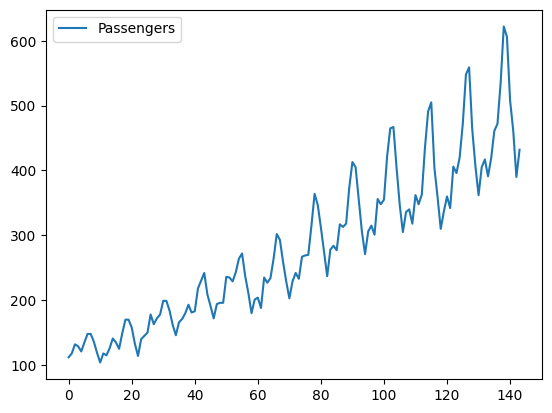

In [2]:
import matplotlib.pyplot as plt

dataframe.plot(y = 'Passengers')
plt.show()

This shows a very typical time series that shows a trend (upward) as well as seasonal spikes (big bumps) and noise (little bumps). This should be great for our LSTM!

We now scale the data to between 0 and 1:

In [3]:
from sklearn.preprocessing import MinMaxScaler

dataset = dataframe.values

# Change to float32 and scale to 0 to 1
# scaled_value = (value - min) / (max - min)
dataset = dataset.astype('float32')
#scaler = MinMaxScaler(feature_range = (0, 1))
#dataset = scaler.fit_transform(dataset)

print(dataset)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


Let's now import all the libraries that we need.

In [4]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Set the random number seed so that we have reproducible results
np.random.seed(7)

## Data and Training Configuration

We now create some hyperparameter constants.


In [5]:
"""
Adjust these to control # of epochs, etc.
"""
batch_size = 1
look_back = 5
hidden_size = 128
num_layers = 1
num_epochs = 4000
TRAIN_PERCENT = 0.67

## Generating Data

Now we will create a data generator to produce the test data. This generator takes the sample data we got out of our Pandas dataframe and scaled, and produces a window of data together with the target output. 

The "look_back" parameter controls the size of the input window. For example, suppose we have a time series of 1, 7, 3, 5, 2, 15, 12, 6, 3. Then with a look_back of 1, we have:

| X   | Y |  
|:---:|:---:|
|1    |7    |
|7    |3    |
|3    |5    |
|5    |2    |
|2    |15   |
|15   |12   |
|12   |6    |
|6    |3    |

With a look_back of 3, we have:

| X     | Y   |  
|:-----:|:---:|
|1,7,3  |5    |
|7,3,5  |2    |
|3,5,2  |15   |
|5,2,15 |12   |
|2,15,12|6    |
|15,12,6|3    |

Here is the code for the data generator, together with code to set up the training and testing data:

In [6]:
# Figure out how many vectors for training and how many for
# testing.

train_size = int(len(dataset) * TRAIN_PERCENT)
test_size = len(dataset) - train_size

# Slice the dataset accordingly
train, test  = dataset[:train_size], dataset[train_size:]

# Generate the datasets with the given look_back.
def create_dataset(dataset, look_back=look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        feature = dataset[i : i + look_back]
        target = dataset[i + 1 :i + look_back + 1]
        dataX.append(feature)
        dataY.append(target)
    return torch.tensor(np.array(dataX)), torch.tensor(np.array(dataY))

# Call create_dataset to make the training and testing sets.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)


torch.Size([91, 5, 1]) torch.Size([91, 5, 1])
torch.Size([43, 5, 1]) torch.Size([43, 5, 1])


## Creating the LSTM

Now that we have our data generator, let's actually create the LSTM. The data we created is presented as a row vector of "look_back" columns, so our LSTM should be configured to accept this.


In [7]:
# Create our LSTM
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 1, hidden_size = hidden_size, num_layers = num_layers, batch_first= True)
        self.output = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.output(x)
        return x

model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(trainX, trainY), batch_size = batch_size)
 
for epoch in range(num_epochs):
    model.train()
    for dataX, dataY in loader:
        y = model(dataX)
        loss = loss_fn(y, dataY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(trainX)
        train_rmse = np.sqrt(loss_fn(y_pred, trainY))
        y_pred = model(testX)
        test_rmse = np.sqrt(loss_fn(y_pred, testY))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 213.9398, test RMSE 413.2439
Epoch 100: train RMSE 53.2738, test RMSE 204.4859
Epoch 200: train RMSE 46.3634, test RMSE 184.1861
Epoch 300: train RMSE 33.4900, test RMSE 119.6059
Epoch 400: train RMSE 29.3629, test RMSE 101.2489
Epoch 500: train RMSE 25.4350, test RMSE 89.2767
Epoch 600: train RMSE 23.7484, test RMSE 82.9038
Epoch 700: train RMSE 22.9681, test RMSE 79.1512
Epoch 800: train RMSE 22.5730, test RMSE 81.2193
Epoch 900: train RMSE 24.4335, test RMSE 79.4673
Epoch 1000: train RMSE 23.6213, test RMSE 80.2289
Epoch 1100: train RMSE 24.8346, test RMSE 77.9225
Epoch 1200: train RMSE 24.3354, test RMSE 76.6656
Epoch 1300: train RMSE 22.9779, test RMSE 77.7171
Epoch 1400: train RMSE 23.2874, test RMSE 74.5064
Epoch 1500: train RMSE 20.4331, test RMSE 72.0366
Epoch 1600: train RMSE 18.4959, test RMSE 71.0189
Epoch 1700: train RMSE 19.7440, test RMSE 70.6419
Epoch 1800: train RMSE 18.6877, test RMSE 73.8544
Epoch 1900: train RMSE 18.2677, test RMSE 73.8921
Epoch 

## Testing our Model

We can now call "predict" on our test and train data and plot out the first 10 training and testing predictions:


Training rmse: 17.536535263061523

Testing rmse: 17.536535263061523


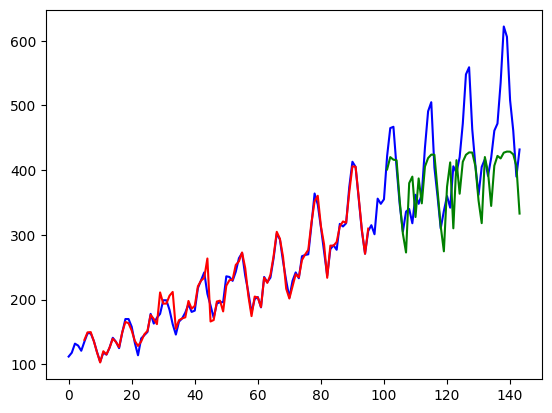

In [10]:
model.eval()
with torch.no_grad():
    y_pred = model(trainX)
    train_rmse = np.sqrt(loss_fn(y_pred, trainY))
    y_pred = model(testX)
    test_rmse = np.sqrt(loss_fn(y_pred, testY))
    print("\nTraining rmse:", train_rmse.item())
    print("\nTesting rmse:", train_rmse.item())

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset) * np.nan
    y_pred = model(trainX)
    y_pred = y_pred[:, -1, :]
    train_plot[look_back:train_size] = model(trainX)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset) * np.nan
    test_plot[train_size+look_back:len(dataset)] = model(testX)[:, -1, :]
# plot
plt.plot(dataset, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

We can see it correctly "predicts" the training data, and performs well for a little while in our test data before failing to predict later values. Note this is a very simple model and we have only trained it for 4000 epochs. Try playing around with the hyperparameters and see if you can get a better result. Some things to try: increase the number of LSTM layers to 2, increase the lookback and the number of epochs.
